In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# from preprocessing.preprocessing import ecb_pipeline_en, fast_detect

import time

import gc

from tqdm import tqdm


torch.set_default_dtype(torch.float32)

In [2]:
FILENAME = "data/train_series.csv"
FILENAME_ECB = "data/ecb_data_preprocessed.csv"
FILENAME_FED = "data/fed_data_preprocessed.csv"

In [3]:
returns = pd.read_csv(FILENAME, index_col=0)
ecb = pd.read_csv(FILENAME_ECB, index_col=0)
fed = pd.read_csv(FILENAME_FED, index_col=0)

In [4]:
returns = pd.get_dummies(returns, columns=["Index Name"])

In [5]:
returns["Sign"] = (returns["Index + 1"] > 0).astype(int)

In [6]:
returns_ecb = returns["index ecb"]
returns_fed = returns["index fed"]
# returns_index_name = returns["Index Name"]

In [7]:
y = returns["Sign"]

In [8]:
y.value_counts()

0    4930
1    4016
Name: Sign, dtype: int64

In [9]:
small_dataset_size = len(y)
y.iloc[:small_dataset_size].value_counts()

0    4930
1    4016
Name: Sign, dtype: int64

In [10]:
returns = returns.drop(["index ecb", "index fed", "Sign", "Index + 1"], axis=1)

In [11]:
nontextual_cols = ['Index - 9',
 'Index - 8',
 'Index - 7',
 'Index - 6',
 'Index - 5',
 'Index - 4',
 'Index - 3',
 'Index - 2',
 'Index - 1',
 'Index - 0',
 'Index Name_CVIX Index',
 'Index Name_EURUSD Curncy',
 'Index Name_EURUSDV1M Curncy',
 'Index Name_MOVE Index',
 'Index Name_SPX Index',
 'Index Name_SRVIX Index',
 'Index Name_SX5E Index',
 'Index Name_V2X Index',
 'Index Name_VIX Index']
nb_nontextfeatures = len(nontextual_cols)

In [12]:
idx_arr = np.arange(len(y))

In [13]:
# 60% train, 20% val, 20% test

idx_, idx_test, y_, y_test = train_test_split(
    idx_arr, y, test_size=0.1, train_size=0.9,
    random_state=0, stratify=y.iloc[:small_dataset_size]
    )

idx_train, idx_val, y_train, y_val = train_test_split(
    idx_, y_, test_size=0.1, train_size=0.9,
    random_state=42, stratify=y_
    )

In [14]:
returns_train = returns.iloc[idx_train]
returns_val = returns.iloc[idx_val]
returns_test = returns.iloc[idx_test]

returns_ecb_train = returns_ecb.iloc[idx_train]
returns_ecb_val = returns_ecb.iloc[idx_val]
returns_ecb_test = returns_ecb.iloc[idx_test]

returns_fed_train = returns_fed.iloc[idx_train]
returns_fed_val = returns_fed.iloc[idx_val]
returns_fed_test = returns_fed.iloc[idx_test]

In [15]:
y.iloc[:100].value_counts()

0    53
1    47
Name: Sign, dtype: int64

In [16]:
returns.head()

,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,Index Name_CVIX Index,Index Name_EURUSD Curncy,Index Name_EURUSDV1M Curncy,Index Name_MOVE Index,Index Name_SPX Index,Index Name_SRVIX Index,Index Name_SX5E Index,Index Name_V2X Index,Index Name_VIX Index
0,0.001045,0.005841,0.003832,-0.027519,-0.103565,-0.045086,-0.011265,0.005164,0.054050,0.015779,0,0,0,0,0,0,0,1,0
1,-0.021497,0.007891,-0.013175,-0.008436,0.000000,0.026303,0.000556,0.001455,0.007422,0.000000,0,0,0,1,0,0,0,0,0
2,-0.001872,-0.008154,0.023588,0.004086,0.003493,0.003300,0.000885,-0.011304,0.005040,0.000156,0,0,0,0,1,0,0,0,0
3,0.004980,-0.000864,0.001677,0.000000,0.006030,-0.001083,0.000419,0.001492,0.001018,-0.002582,0,0,0,0,1,0,0,0,0
4,0.000360,-0.001893,0.005579,-0.003056,-0.001171,-0.001623,-0.002350,-0.006444,-0.000729,-0.000365,0,1,0,0,0,0,0,0,0


In [17]:
# del returns, y
# gc.collect()

In [18]:
returns.describe()

,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,Index Name_CVIX Index,Index Name_EURUSD Curncy,Index Name_EURUSDV1M Curncy,Index Name_MOVE Index,Index Name_SPX Index,Index Name_SRVIX Index,Index Name_SX5E Index,Index Name_V2X Index,Index Name_VIX Index
count,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000
mean,-0.000008,0.000200,0.000255,0.000339,0.000090,0.000407,0.000644,0.000988,0.000847,0.000950,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
std,0.040715,0.040788,0.039987,0.040587,0.039230,0.039386,0.040104,0.039900,0.040365,0.040699,0.314287,0.314287,0.314287,0.314287,0.314287,0.314287,0.314287,0.314287,0.314287
min,-0.355095,-0.355095,-0.355095,-0.355095,-0.355095,-0.355095,-0.350588,-0.350588,-0.345301,-0.345301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.011516,-0.011160,-0.011122,-0.010843,-0.010698,-0.010363,-0.010435,-0.010155,-0.010360,-0.010515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.008365,0.008304,0.008276,0.008358,0.008156,0.008573,0.008795,0.008732,0.008855,0.009020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.382167,0.382167,0.382167,0.496008,0.496008,0.496008,0.768245,0.768245,0.768245,0.768245,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
# ct = ColumnTransformer([
#     ('Standard Scaler', StandardScaler(), [
#                                     'Index - 9',
#                                     'Index - 8',
#                                     'Index - 7',
#                                     'Index - 6',
#                                     'Index - 5',
#                                     'Index - 4',
#                                     'Index - 3',
#                                     'Index - 2',
#                                     'Index - 1',
#                                     'Index - 0'])
# ], remainder='passthrough')

In [20]:
# returns_train = pd.DataFrame(ct.fit_transform(returns_train), columns=returns_train.columns)
# returns_val = pd.DataFrame(ct.transform(returns_val), columns=returns_train.columns)
# returns_test = pd.DataFrame(ct.transform(returns_test), columns=returns_train.columns)

In [21]:
returns_train.head()

,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,Index Name_CVIX Index,Index Name_EURUSD Curncy,Index Name_EURUSDV1M Curncy,Index Name_MOVE Index,Index Name_SPX Index,Index Name_SRVIX Index,Index Name_SX5E Index,Index Name_V2X Index,Index Name_VIX Index
3534,-0.049060,-0.040567,-0.024014,0.012658,-0.020061,-0.005588,-0.030342,0.028812,0.038370,-0.012848,0,0,1,0,0,0,0,0,0
5161,-0.009237,-0.003332,-0.013174,-0.004549,0.001697,0.005962,-0.003199,-0.010558,0.002874,0.001792,0,1,0,0,0,0,0,0,0
2825,-0.003705,0.003926,-0.001332,0.001110,-0.011753,-0.001797,-0.007600,0.005574,0.001276,0.008813,0,1,0,0,0,0,0,0,0
7142,-0.015253,0.067968,-0.001604,0.033489,0.014383,0.000000,-0.010156,0.030114,-0.022277,0.005800,0,0,0,0,1,0,0,0,0
6174,-0.031336,0.004195,0.017196,0.096325,-0.027058,-0.051207,-0.000578,-0.048530,-0.023935,-0.012500,0,0,0,1,0,0,0,0,0


# The textual data

In [142]:
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [23]:
def parse_text_idx(string):
    index_text = [int(i) for i in string.split(",")]
    return index_text

In [136]:
indices_text_train = pd.DataFrame()
indices_text_val = pd.DataFrame()
indices_text_test = pd.DataFrame()

In [137]:
indices_text_train["index ecb"] = returns_ecb_train.apply(parse_text_idx)
indices_text_train["index fed"] = returns_fed_train.apply(parse_text_idx)

indices_text_val["index ecb"] = returns_ecb_val.apply(parse_text_idx)
indices_text_val["index fed"] = returns_fed_val.apply(parse_text_idx)

indices_text_test["index ecb"] = returns_ecb_test.apply(parse_text_idx)
indices_text_test["index fed"] = returns_fed_test.apply(parse_text_idx)

In [30]:
indices_text_train

,index ecb,index fed
3534,[605],[389]
5161,[1036],[134]
2825,[1581],[336]
7142,"[1614, 634]",[316]
6174,[318],[376]
...,...,...
1160,[1082],[13]
7007,[210],[164]
8233,[653],[594]
1815,[1237],[32]


In [53]:
example_mask = indices_text_train["index ecb"].apply(lambda x : 1008 in x)
indices_text_train[example_mask]

,index ecb,index fed
7587,"[1008, 531, 1319, 1389]",[168]
2180,"[1008, 531, 1319, 1389]",[168]
8232,"[1008, 531, 1319, 1389]",[168]
7649,"[1008, 531, 1319, 1389]",[168]
6039,"[1008, 531, 1319, 1389]",[168]
5589,"[1008, 531, 1319, 1389]",[168]
5946,"[1008, 531, 1319, 1389]",[168]
4815,"[1008, 531, 1319, 1389]",[168]
1613,"[1008, 531, 1319, 1389]",[168]
7951,"[1008, 531, 1319, 1389]",[168]


In [32]:
y_train[example_mask]

array([1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0])

In [99]:
index_times = ['Index - 9',
 'Index - 8',
 'Index - 7',
 'Index - 6',
 'Index - 5',
 'Index - 4',
 'Index - 3',
 'Index - 2',
 'Index - 1',
 'Index - 0']

std_col_names = ["std3 " + name for name in index_times]

In [84]:
returns_index_times = returns_train[index_times].astype(float)
returns_index_times.iloc[0]

Index - 9   -0.049060
Index - 8   -0.040567
Index - 7   -0.024014
Index - 6    0.012658
Index - 5   -0.020061
Index - 4   -0.005588
Index - 3   -0.030342
Index - 2    0.028812
Index - 1    0.038370
Index - 0   -0.012848
Name: 3534, dtype: float64

In [112]:
rolling_std_train = returns_train[index_times].astype(float).rolling(window=3, axis=1, center=False).std()
rolling_std_train = rolling_std_train.drop(columns=['Index - 9', 'Index - 8'])
rolling_std_train.columns = std_col_names[-8:]

rolling_std_val = returns_val[index_times].astype(float).rolling(window=3, axis=1, center=False).std()
rolling_std_val = rolling_std_val.drop(columns=['Index - 9', 'Index - 8'])
rolling_std_val.columns = std_col_names[-8:]

rolling_std_test = returns_test[index_times].astype(float).rolling(window=3, axis=1, center=False).std()
rolling_std_test = rolling_std_test.drop(columns=['Index - 9', 'Index - 8'])
rolling_std_test.columns = std_col_names[-8:]

rolling_std_train

,std3 Index - 7,std3 Index - 6,std3 Index - 5,std3 Index - 4,std3 Index - 3,std3 Index - 2,std3 Index - 1,std3 Index - 0
3534,0.012737,0.027239,0.020129,0.016396,0.012436,0.029708,0.037220,0.027234
5161,0.004953,0.005365,0.007467,0.005287,0.004584,0.008277,0.006727,0.007463
2825,0.003905,0.002631,0.006832,0.006746,0.005001,0.006603,0.006718,0.003781
7142,0.044633,0.034787,0.017570,0.016800,0.012330,0.020943,0.027427,0.026218
6174,0.025122,0.049864,0.062508,0.079133,0.025324,0.028490,0.023979,0.018411
...,...,...,...,...,...,...,...,...
1160,0.019376,0.008602,0.010306,0.009769,0.014544,0.063652,0.069971,0.064639
7007,0.029202,0.015134,0.017234,0.008815,0.008802,0.004269,0.026487,0.022863
8233,0.041342,0.012998,0.008060,0.056133,0.049985,0.067473,0.025794,0.020503
1815,0.008642,0.009656,0.002939,0.005509,0.005044,0.008843,0.006455,0.011826


In [39]:
((returns_index_times["Index - 0"] - returns_index_times["Index - 1"])[y==1] > 0).mean()

0.5015375153751538

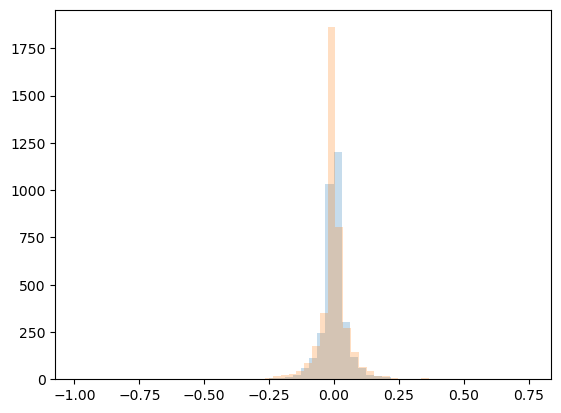

In [43]:
plt.hist((returns_index_times["Index - 0"] - returns_index_times["Index - 1"])[y_train==1], bins=50, alpha=.25)
plt.hist((returns_index_times["Index - 0"] - returns_index_times["Index - 1"])[y_train==0], bins=50, alpha=.25)
plt.show()

In [45]:
example_mask = indices_text_train["index ecb"].apply(lambda x : 634 in x)
example_mask.shape[0]

7245

In [46]:
y_train[example_mask].mean()

0.325

In [47]:
indices_text_train[example_mask]

,index ecb,index fed
7142,"[1614, 634]",[316]
8181,"[1614, 634]",[316]
7647,"[1614, 634]",[316]
8503,"[1614, 634]",[316]
5418,"[1614, 634]",[316]
...,...,...
3678,"[1614, 634]",[316]
6546,"[1614, 634]",[316]
7135,"[1614, 634]",[316]
1813,"[1614, 634]",[316]


In [48]:
returns_train[example_mask]

,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,Index Name_CVIX Index,Index Name_EURUSD Curncy,Index Name_EURUSDV1M Curncy,Index Name_MOVE Index,Index Name_SPX Index,Index Name_SRVIX Index,Index Name_SX5E Index,Index Name_V2X Index,Index Name_VIX Index
7142,-0.015253,0.067968,-0.001604,0.033489,0.014383,0.000000,-0.010156,0.030114,-0.022277,0.005800,0,0,0,0,1,0,0,0,0
8181,-0.008118,-0.001288,0.010823,0.044735,-0.021079,-0.072269,-0.017400,-0.052656,-0.062690,-0.029992,0,0,0,1,0,0,0,0,0
7647,-0.017589,0.000000,0.019436,-0.087143,0.013998,-0.008118,-0.001288,0.010823,0.044735,-0.021079,0,0,0,1,0,0,0,0,0
8503,0.000000,0.019436,-0.087143,0.013998,-0.008118,-0.001288,0.010823,0.044735,-0.021079,-0.072269,0,0,0,1,0,0,0,0,0
5418,-0.038266,0.001477,0.026648,0.007313,-0.041459,0.015485,0.006175,-0.015328,0.025662,0.017190,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3678,0.078412,-0.018036,-0.050100,0.138793,0.035414,-0.078539,-0.014396,-0.141225,-0.076316,0.008376,0,0,0,0,0,0,0,0,1
6546,0.000563,0.000984,-0.008746,0.001133,-0.003402,-0.005554,-0.015397,-0.023624,-0.007751,-0.013710,0,0,0,0,0,1,0,0,0
7135,-0.001830,0.004387,-0.004387,-0.007632,0.003777,-0.000460,-0.002395,-0.002585,-0.000185,0.000832,0,1,0,0,0,0,0,0,0
1813,-0.086459,0.078412,-0.018036,-0.050100,0.138793,0.035414,-0.078539,-0.014396,-0.141225,-0.076316,0,0,0,0,0,0,0,0,1


In [121]:
indices_text_train.astype(str).groupby(["index ecb", "index fed"]).size().sort_values()

index ecb     index fed
[350]         [614]          3
[627]         [401]          4
[107]         [20]           4
[1566, 667]   [389]          4
[1068, 1358]  [220]          4
                          ... 
[673]         [586]         75
[643]         [734]         79
[1614, 634]   [316]         80
[1325]        [459]         85
[571]         [497]        146
Length: 521, dtype: int64

In [182]:
biggest_mask = indices_text_train.apply(lambda x : x["index ecb"][0]==1325 and x["index fed"][0] == 459, axis=1)
biggest_mask.sum()

85

In [77]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import log_loss, accuracy_score, f1_score

In [161]:
xgbc = XGBClassifier()
xgbc.fit(rolling_std_train[example_mask], y_train[example_mask])

[02:36:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\huuta\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\huuta\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

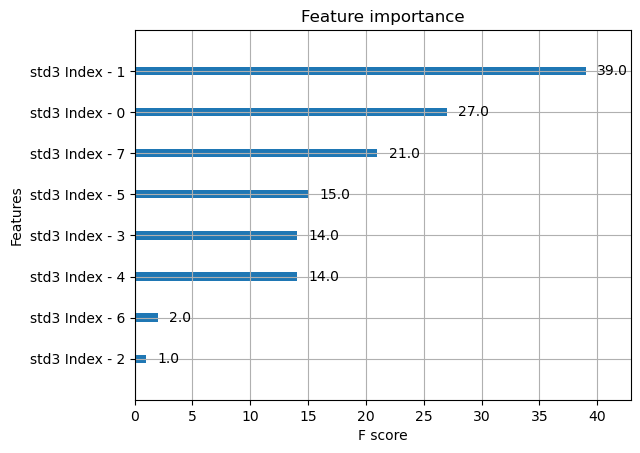

In [162]:
plot_importance(xgbc)

In [163]:
x_train = pd.concat([rolling_std_train, returns_train], axis=1)

xgbc.fit(x_train[biggest_mask], y_train[biggest_mask])

[02:36:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\huuta\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\huuta\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

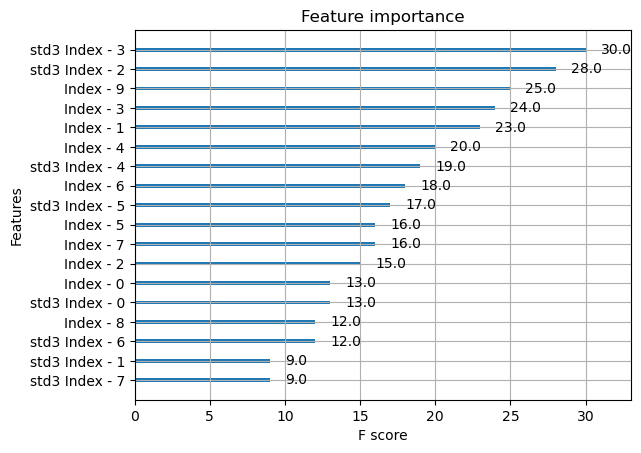

In [164]:
plot_importance(xgbc)

In [179]:
mask_test = indices_text_test.apply(lambda x : x["index ecb"][0]==1325 and x["index fed"][0] == 459, axis=1)

In [177]:
x_test = pd.concat([rolling_std_test, returns_test], axis=1)
x_test[mask_test]

,std3 Index - 7,std3 Index - 6,std3 Index - 5,std3 Index - 4,std3 Index - 3,std3 Index - 2,std3 Index - 1,std3 Index - 0,Index - 9,Index - 8,...,Index - 0,Index Name_CVIX Index,Index Name_EURUSD Curncy,Index Name_EURUSDV1M Curncy,Index Name_MOVE Index,Index Name_SPX Index,Index Name_SRVIX Index,Index Name_SX5E Index,Index Name_V2X Index,Index Name_VIX Index
6736,0.019995,0.020586,0.021727,0.036214,0.020398,0.020756,0.020487,0.013250,-0.036056,-0.019564,...,0.032489,0,0,0,1,0,0,0,0,0
6086,0.002823,0.003201,0.001607,0.001103,0.003957,0.005530,0.009827,0.009651,0.000000,0.005035,...,-0.001978,0,0,0,0,0,1,0,0,0
5909,0.018560,0.017514,0.033074,0.054679,0.056699,0.102345,0.061158,0.065090,0.028690,0.000000,...,0.007621,0,0,0,0,0,0,0,0,1
2222,0.001464,0.003793,0.003646,0.006791,0.004333,0.002129,0.001575,0.002680,-0.001059,0.000791,...,0.001661,0,0,0,0,1,0,0,0,0
330,0.001478,0.001086,0.002402,0.003402,0.004960,0.005874,0.001746,0.002216,-0.004515,-0.003778,...,0.005964,0,0,0,0,0,1,0,0,0
6997,0.003793,0.003646,0.006791,0.004333,0.002129,0.001575,0.002680,0.003196,0.000791,0.001832,...,0.001302,0,0,0,0,1,0,0,0,0
6449,0.041637,0.042423,0.005600,0.052954,0.043201,0.035610,0.047668,0.032277,0.057346,0.069025,...,-0.020513,0,0,0,0,0,0,0,1,0
8138,0.001540,0.001906,0.002073,0.004296,0.002823,0.003201,0.001607,0.001103,0.000000,-0.002588,...,-0.000917,0,0,0,0,0,1,0,0,0
7822,0.020880,0.017159,0.019995,0.020586,0.021727,0.036214,0.020398,0.020756,0.001715,-0.001745,...,0.046624,0,0,0,1,0,0,0,0,0
563,0.004986,0.002819,0.000523,0.003985,0.003346,0.003858,0.002957,0.004806,0.005090,-0.004882,...,0.005626,0,0,0,0,0,0,1,0,0


In [178]:
preds_test_proba = xgbc.predict_proba(x_test[mask_test])
print("log loss: ", log_loss(y_test[mask_test], preds_test_proba))
print("accuracy: ", accuracy_score(y_test[mask_test],  xgbc.predict(x_test[mask_test])))

log loss:  0.8942543609688679
accuracy:  0.6111111111111112


# Translation

# HuggingFace Transformers

# Loading data

In [18]:
from model.framework_dataset import get_data_loader
from model.framework_model import MyModel

# Loading model

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Other example

In [20]:
config = {

    "method": "model_03",

    "learning_rate": 1e-3,

    "weight_decay": 0,

    "batch_size": 2,

    "layers": 4,

    "mlp_hidden_dim": 128,

    "dropout": 0,

    "separate": False,
    
    "max_corpus_len": 2,

    "max_epochs": 20,

    "scheduler_step": -1,

    "scheduler_ratio": 0.1,

    "scheduler_last_epoch": 20,

    "early_stopping": False,

    "preload": False

}

In [21]:
print(config["method"])

model_03


In [22]:
train_set, train_loader, tokenizer, steps = get_data_loader(
    returns_train, ecb, fed, y_train, method=config["method"],
    separate=config["separate"], max_corpus_len=config["max_corpus_len"],
    batch_size=config["batch_size"]
)

val_set, val_loader, tokenizer, steps = get_data_loader(
    returns_val, ecb, fed, y_val, method=config["method"],
    separate=config["separate"], max_corpus_len=config["max_corpus_len"],
    batch_size=config["batch_size"]
)

test_set, test_loader, tokenizer, steps = get_data_loader(
    returns_test, ecb, fed, y_test, method=config["method"],
    separate=config["separate"], max_corpus_len=config["max_corpus_len"],
    batch_size=config["batch_size"]
)

In [23]:
train_set[0]

((['In this context, the outcome of the UK’s EU referendum is triggering a debate not just on the future relationship between the EU and the UK, but also – and perhaps more importantly – on how to improve the functioning of the EU and of Economic and Monetary Union (EMU) as one of its key elements.\r\nSo today I will be considering how we could boost support and strengthen the institutional arrangements for European integration.\r\nIn material terms, the EU has facilitated a level of prosperity unprecedented in European history, if only because by ensuring peace it prevented the strife and destruction of the past.\r\nPeople believe in Europe and European public goods when they are tangible and deliver results.\r\nEconomically, the pace of recovery in the euro area remains unsatisfactory, with unemployment levels still too high.\r\nRisk sharing involves both the public and private sectors, for example by ensuring the same level of deposit protection through a European deposit insurance 

In [24]:
returns_train.iloc[0]

Index - 9                      1.079978
Index - 8                     -1.197337
Index - 7                     -0.608429
Index - 6                      1.727739
Index - 5                       0.19114
Index - 4                      0.161762
Index - 3                     -0.941655
Index - 2                     -1.288233
Index - 1                      0.053673
Index - 0                      0.267276
index ecb                           309
index fed                           492
Index Name_CVIX Index                 0
Index Name_EURUSD Curncy              0
Index Name_EURUSDV1M Curncy           1
Index Name_MOVE Index                 0
Index Name_SPX Index                  0
Index Name_SRVIX Index                0
Index Name_SX5E Index                 0
Index Name_V2X Index                  0
Index Name_VIX Index                  0
Name: 0, dtype: object

In [25]:
def text_print(text, line_char_lim=150):
    text_ = text.split('\n')
    for subtext in text_:
        n = len(subtext)
        k = 0
        while k <= n:
            print(subtext[k:min(n, k + line_char_lim)])
            k += line_char_lim
        print('\n')

In [26]:
model = MyModel(method=config["method"],
                layers=config["layers"],
                mlp_hidden_dim=config["mlp_hidden_dim"],
                separate=config["separate"],
                dropout=config["dropout"]).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
model

MyModel(
  (nontext_network): NontextualNetwork()
  (corpus_encoder): CorpusEncoder(
    (encoder): CorpusEncoder(
      (doc_encoder): DocumentEncoder(
        (text_encoder): DistilBertModel(
          (embeddings): Embeddings(
            (word_embeddings): Embedding(30522, 768, padding_idx=0)
            (position_embeddings): Embedding(512, 768)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (transformer): Transformer(
            (layer): ModuleList(
              (0): TransformerBlock(
                (attention): MultiHeadSelfAttention(
                  (dropout): Dropout(p=0.1, inplace=False)
                  (q_lin): Linear(in_features=768, out_features=768, bias=True)
                  (k_lin): Linear(in_features=768, out_features=768, bias=True)
                  (v_lin): Linear(in_features=768, out_features=768, bias=True)
                  (out_lin): Linear(in_feat

In [28]:
batch = next(iter(train_loader))
batch

{'X_text': tensor([[[ 101, 1999, 2023,  ..., 2011, 2216,  102],
          [ 101,  102,    0,  ...,    0,    0,    0],
          [ 101, 1996, 3795,  ..., 1010, 3105,  102],
          [ 101,  102,    0,  ...,    0,    0,    0]],
 
         [[ 101, 2256, 2490,  ..., 3296, 3930,  102],
          [ 101,  102,    0,  ...,    0,    0,    0],
          [ 101, 3361, 9211,  ..., 8485, 2015,  102],
          [ 101,  102,    0,  ...,    0,    0,    0]]]),
 'X_mask': tensor([[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 0,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 0,  ..., 0, 0, 0]],
 
         [[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 0,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 0,  ..., 0, 0, 0]]]),
 'X_ind': tensor([[ 1.0800, -1.1973, -0.6084,  1.7277,  0.1911,  0.1618, -0.9417, -1.2882,
           0.0537,  0.2673,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [-0.8345,  0.7644, -0.1862, 

In [29]:
# First text of first ecb corpus of batch
# batch['X_text'][0][0]

In [30]:
# ECB texts
# tokenizer(train_set[0][0][0], padding='max_length', max_length=512, truncation=True)["input_ids"][0]

In [31]:
# # Test output
# with torch.no_grad():
#     my_model.eval()
#     batch = next(iter(train_loader))
#     print(batch)

#     with torch.no_grad():
#         X_ind, y = batch
#         my_model_output = my_model(None, None, X_ind.float().to(device))

#     print(my_model_output.size(0)/64)

# Testing train code

In [32]:
from train import train, evaluate

In [33]:
model.classifier

ClassificationHead(
  (mlp): SimpleMLP(
    (layers): Sequential(
      (0): Linear(in_features=787, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): ReLU()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): ReLU()
      (8): Dropout(p=0, inplace=False)
      (9): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [34]:
import optuna
from torch.optim import Adam

In [35]:
epochs = config["max_epochs"]
lr = config["learning_rate"]
method = config["method"]
optimizer = Adam(model.parameters(),
                    lr=config["learning_rate"],
                    weight_decay=config["weight_decay"])
criterion = nn.BCEWithLogitsLoss()
sigmoid = nn.Sigmoid()

for epoch in range(1, epochs+1):
    total_loss = 0
    total_entries = 0
    correct = 0
    model.train()

    with tqdm(train_loader, unit="batch") as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            optimizer.zero_grad()
            
            # Get inputs
            if method is None:
                X_ind, y_ = batch
                X_ind = torch.Tensor(X_ind).float().to(device)
                y_ = torch.Tensor(y_).float().to(device)
                
                X_text = None
                X_mask = None
            else:
                X_ind = batch["X_ind"].to(device)
                y_ = batch["label"].to(device)

                if config["separate"]:
                    X_ecb = batch["X_ecb"].to(device)
                    X_ecb_att = batch["X_ecb_mask"].to(device)
                    X_fed = batch["X_fed"].to(device)
                    X_fed_att = batch["X_fed_mask"].to(device)

                    X_text = (X_ecb, X_fed)
                    X_mask = (X_ecb_att, X_fed_att)
                else:
                    X_text = (batch["X_text"].to(device),)
                    X_mask = (batch["X_mask"].to(device),)
            
            # Compute output
            output = model(X_text, X_mask, X_ind)
            # print(output)

            # Compute loss
            loss = criterion(output, y_)
            
            # Update model
            loss.backward()
            optimizer.step()
            # Computing predictions

            ## Batch loss
            batch_loss = loss.item()

            # Accuracy computation
            output_proba = sigmoid(output)
            batch_size_ = y_.size(0)
            preds = output_proba.round()
            correct += (preds == y_).sum().item()
            ## Total loss with no reduction
            total_loss += loss.item() * batch_size_
            total_entries += batch_size_
            tepoch.set_postfix(loss=total_loss/total_entries,
                                accuracy=100. * correct/total_entries,
                                batch_loss=batch_loss)



Epoch 20: 100%|██████████| 41/41 [00:37<00:00,  1.10batch/s, accuracy=71.6, batch_loss=0.279, loss=0.55]  


8

In [27]:
def objective(trial):
      config ={

                "method": None,

                "learning_rate": 10**trial.suggest_float("lr_exp", -6, -2),

                "weight_decay": 10**trial.suggest_float("weight_decay_exp", -6, -2),

                "batch_size": 64,

                "layers": trial.suggest_int("layers", 2, 6),

                "mlp_hidden_dim": 64,

                "separate": False,

                "max_corpus_len": 1,

                "dropout": trial.suggest_float("dropout", 0.2, 0.7),

            }
      model = MyModel(
            nontext_dim=nb_nontextfeatures, method=config["method"],
            separate=False, dropout=config["dropout"], mlp_hidden_dim=config["mlp_hidden_dim"]
            ).to(device)

      _, train_loader, tokenizer, _ = get_data_loader(
      returns_train, ecb, fed, y_train, method=config["method"],
      separate=config["separate"], max_corpus_len=config["max_corpus_len"],
      batch_size=config["batch_size"]
      )

      _, val_loader, _, _ = get_data_loader(
      returns_val, ecb, fed, y_val, method=config["method"],
      separate=config["separate"], max_corpus_len=config["max_corpus_len"],
      batch_size=config["batch_size"]
      )

      _, _, _, _ = get_data_loader(
      returns_test, ecb, fed, y_test, method=config["method"],
      separate=config["separate"], max_corpus_len=config["max_corpus_len"],
      batch_size=config["batch_size"]
      )

      _, _, eval_f1s = train(model, train_loader=train_loader, val_loader=val_loader,config=config,
            device=device, max_epochs=20, eval_every=5, name=f"no_nlp_{config['learning_rate']}")
      return eval_f1s[-1]

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, n_jobs=1)

[I 2023-03-09 01:12:10,663] A new study created in memory with name: no-name-06989159-1152-408d-b2ac-beadafbca427
Evaluation: 100%|██████████| 28/28 [00:06<00:00,  4.43batch/s, accuracy=56.8, loss=0.68] 
[I 2023-03-09 01:19:25,151] Trial 0 finished with value: 0.44857142857142857 and parameters: {'lr_exp': -3.820881786827314, 'weight_decay_exp': -5.1198501828596985, 'layers': 6, 'dropout': 0.381783652210378}. Best is trial 0 with value: 0.44857142857142857.
Evaluation: 100%|██████████| 28/28 [00:06<00:00,  4.39batch/s, accuracy=57, loss=0.681]  
[I 2023-03-09 01:26:18,716] Trial 1 finished with value: 0.4588318085855032 and parameters: {'lr_exp': -3.159445455594589, 'weight_decay_exp': -3.97802436593108, 'layers': 2, 'dropout': 0.43882404892551674}. Best is trial 1 with value: 0.4588318085855032.
Evaluation: 100%|██████████| 28/28 [00:06<00:00,  4.64batch/s, accuracy=56.8, loss=0.681]
[I 2023-03-09 01:33:01,510] Trial 2 finished with value: 0.44857142857142857 and parameters: {'lr_exp'

In [29]:
study.best_params

{'lr_exp': -5.961894715777749,
 'weight_decay_exp': -2.427291780099218,
 'layers': 4,
 'dropout': 0.4329101757872429}

In [30]:
study.best_value

0.5872945357618835